<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/14_deep_computer_vision_with_cnns.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

In [1]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use('seaborn-darkgrid')

# ResNet-34

In [ ]:
# residual unit 구현하기
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides = 1, activation = "relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layer = [
            keras.layers.Conv2D(filters, 3, strides = strides,
                                padding = "same", use_bias = False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides = 1,
                                padding = "same", use_bias = False),
            keras.layers.BatchNormalization() ]
        
        self.skip_layers = [] # stride가 1보다 크게 초기설정된 RU 에서만 값을 가진다.
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides = strides,
                                    padding = "same", use_bias = False),
                keras.layers.BatchNormalization() ]
            
        def call(self, inputs):
            Z = inputs
            for layer in self.main_layers:
                Z = layer(Z) # Z는 main_layer들을 따라 흐르며 값이 재구성됨
            skip_Z = inputs # 원본 input
            for layer in self.skip_layers: # skip_layer 가 존재하는 경우에만 실행
                skip_Z = layer(skip_Z)
            return self.activation(Z + skip_Z)

In [ ]:
# ResNet-34
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides = 2, input_shape = [224,224,3],
                              padding = "same", use_bias = False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size = 3, strides = 2, padding = "same"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3: # RU stacks
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides = strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation = "softmax"))

## Using a Pretrained Model

In [5]:
from sklearn.datasets import load_sample_image

china = load_sample_image('china.jpg') / 255
flower = load_sample_image('flower.jpg') / 255
images = np.array([china, flower])

In [3]:
# keras 의 applications 패키지에서 구현된 모델 가져다 쓰기. 
# 이미지넷에 대해 사전학습된 가중치까지 그대로 불러올 수 있다.
model = keras.applications.resnet50.ResNet50(weights="imagenet")

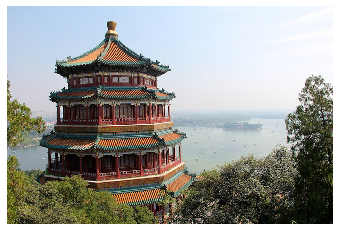

In [6]:
plt.imshow(images[0], interpolation = "nearest")
plt.axis("off")
plt.show()

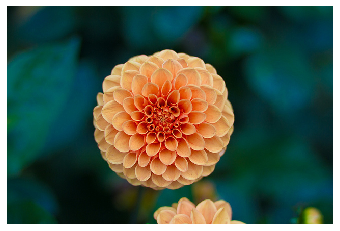

In [7]:
plt.imshow(images[1], interpolation = "nearest")
plt.axis("off")
plt.show()

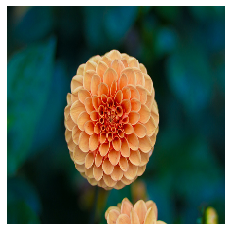

In [8]:
# 각 모델마다 기대하는 input image의 형태가 다를 수 있음.
# tf.image.resize 함수를 통해 적절한 shape로 만들어 줘야함
images_resized = tf.image.resize (images, [224, 224])
plt.imshow(images_resized[1], interpolation = "nearest")
plt.axis("off")
plt.show()

In [9]:
# 사전훈련 모델은 이미지가 적절한 방식으로 전처리된 상태라고 가정.
# preprocess_input 함수를 이용해 처리할 수 있다.
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)

# prediction
Y_proba = model.predict(inputs) # 행(이미지 index), 열(클래스 index)

top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

Image #0
  n02825657 - bell_cote    82.35%
  n03877845 - palace       6.75%
  n03781244 - monastery    4.19%

Image #1
  n03530642 - honeycomb    49.81%
  n13040303 - stinkhorn    33.96%
  n02206856 - bee          4.35%



## Pretrained Models for Transfer Learning

#### data loading

In [10]:
# 텐서플로 데이터셋 적재
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples # 3670
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes # 5개의 꽃 종류 클래스가 있음

# 위 데이터셋은 train셋 이외 별도의 validation, test 셋을 제공하지 않으므로
# 아래와 같이 tfds의 split API를 이용해 직접 나누도록 한다. 10:15:75
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

# # 이미지 샘플
# plt.figure(figsize=(12, 10))
# index = 0
# for image, label in train_set_raw.take(9):
#     index += 1
#     plt.subplot(3, 3, index)
#     plt.imshow(image)
#     plt.title("Class: {}".format(class_names[label]))
#     plt.axis("off")
# plt.show()

#### preprocessing

In [11]:
# 224*224 로 이미지의 크기를 조정하고 Xception에서 기대하는 input으로 전처리하는 함수를 정의
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

# 훈련셋을 섞고, 전처리함수를 모든 데이터 셋에 적용하며, 배치 크기를 설정한 뒤 프리페치를 적용한다.
train_set = train_set_raw.shuffle(1000).repeat()
batch_size = 32
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

#### model

In [ ]:
# 이미지넷에 대해 사전훈련된 Xception 모델을 로드
# 네트워크 최상층(전역평균풀링, 밀집출력층) 제외
# 함수형 API로 현재 task에 맞는 적절한 최상위층 추가
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)


# 가져온 모든 사전학습 layer들을 동결시킴
for layer in base_model.layers:
    layer.trainable = False

# 모델을 컴파일하고 fitting한다.
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5,
                   steps_per_epoch=int(0.75 * dataset_size / batch_size),
                   validation_steps=int(0.15 * dataset_size / batch_size))

# # 위의 결과가 썩 나쁘지 않다면 새로 추가한 최상위층이 잘 훈련된것을 의미
# # 이제 사전훈련 층들의 동결을 해제하고 tuning을 진행한다.
# for layer in base_model.layers:
#     layer.trainable = True

# # 이때의 학습률은 사전훈련 가중치가 훼손되는 것을 피하기 위해 훨씬 작게 설정한다.
# optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True, decay=0.001)
# model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
#               metrics=["accuracy"])
# history = model.fit(train_set, validation_data=valid_set, epochs=40)

# Classification and Localization (분류와 위치추정)

  
물체의 위치추정은 물체 주위의 바운딩 박스(bounding box)를 예측하는  
regression task로써, 물체 중심의 수평,수직 좌표와 높이/너비를 예측하는것이 목적이다.  
4개의 numeric값을 예측하면 되는데, 기존 모델을 크게 바꾸지 않고  
상단에 밀집 출력층만 추가 후, 적절한 손실함수를 설정하여 모델을 완성할 수 있다.  

In [ ]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
# 클래스와 location을 예측 (다중출력)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output])
# 두 개의 loss를 task에 따라 적절한 가중치를 주어 설정
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], 
              optimizer=optimizer, metrics=["accuracy"])
# 훈련을 위한 손실로는 mse를 사용할 수 있으나, 예측의 평가지표로는 IoU가 더 타당하여 널리 사용된다.